In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sklearn as sk
import sklearn.naive_bayes as sknb
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.tree as sktree
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")  # make figures fit
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import sklearn.externals.six as sksix
import IPython.display as ipd
import os
import pydot_ng as pydot

# load the bokeh stuff
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
from bokeh.layouts import column, row
from bokeh.charts import Scatter
from bokeh.charts import TimeSeries
from bokeh.charts import Bar
from bokeh.charts import Histogram
from bokeh.charts import BoxPlot
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
exec(open('useful.py').read())
# make the Pandas tables a little more readable

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

Loading BokehJS ...

## LOAD IN THE CSVS YOU WILL NEED

In [3]:
Master = pd.read_csv("Master.csv")
Salaries = pd.read_csv("Salaries.csv")
Teams = pd.read_csv("Teams.csv")
Batting = pd.read_csv("Batting.csv", parse_dates = ['yearID'])
Appearances = pd.read_csv("Appearances.csv", parse_dates=['yearID'])

## CREATE COPIES OF TABLES TO CREATE THE TABLE YOU NEED 

In [4]:
#MasterSel will comprise of only the variables you are interested in 
# I am particularly interested in weight/ might take birth into account
MasterSel = Master[['playerID','weight','height','birthCountry']]

In [5]:
# quickly examine Master Sel
MasterSel.head(2)

playerID  weight  height birthCountry
0  aardsda01   215.0    75.0          USA
1  aaronha01   180.0    72.0          USA

In [6]:
# looked at NA's there are only a few, so I feel comfortable excluding them
# from my analysis
MasterSel = MasterSel.dropna() 

In [7]:
# Similiar to MasterSel I will narrow down the variables I want from
# the batting table
# BattingSel is also a cut down of the Batting csv
BattingSel = Batting[['playerID','yearID','teamID','G','AB','R','H','RBI','HR','2B','3B','SO']]

In [8]:
# for further analysis we will be checking 
# batting statistics, if we don't have batting data for them we will drop them
# when merging columns will make sure to merge on only those players in batting 
BattingSel = BattingSel.dropna() 

In [9]:
# batting table has the items you want now
BattingSel.head(2)

playerID     yearID teamID   G   AB   R   H   RBI  HR  2B  3B   SO
0  abercda01 1871-01-01    TRO   1    4   0   0   0.0   0   0   0  0.0
1   addybo01 1871-01-01    RC1  25  118  30  32  13.0   0   6   0  0.0

In [10]:
# Positions is the appearances table cut down 
# the variables in this dataframe are the number of times 
# a player has played such position in that given year 
# this will later give us the position of each player
Positions = Appearances[['yearID','playerID', 'G_all','G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_of']]

In [11]:
Positions.head(2)

yearID   playerID  G_all  G_p  G_c  G_1b  G_2b  G_3b  G_ss  G_of
0 1871-01-01  abercda01      1    0    0     0     0     0     1     0
1 1871-01-01   addybo01     25    0    0     0    22     0     3     0

In [12]:
#set all indexes to "playerid" so you can later merge them 
MasterSel = MasterSel.set_index('playerID')
BattingSel = BattingSel.set_index('playerID')
Positions= Positions.set_index('playerID')

In [13]:
# MasterPos will now have POSITIONAL data and weight,height, and birth country 
MasterPos = pd.merge(MasterSel, Positions, left_index=True, right_index=True, how='inner')

In [14]:
#MasterPos.describe()
MasterPos.head()

weight  height birthCountry     yearID  G_all  G_p  G_c  G_1b  \
playerID                                                                   
aardsda01   215.0    75.0          USA 2004-01-01     11   11    0     0   
aardsda01   215.0    75.0          USA 2006-01-01     45   45    0     0   
aardsda01   215.0    75.0          USA 2007-01-01     25   25    0     0   
aardsda01   215.0    75.0          USA 2008-01-01     47   47    0     0   
aardsda01   215.0    75.0          USA 2009-01-01     73   73    0     0   

           G_2b  G_3b  G_ss  G_of  
playerID                           
aardsda01     0     0     0     0  
aardsda01     0     0     0     0  
aardsda01     0     0     0     0  
aardsda01     0     0     0     0  
aardsda01     0     0     0     0

In [15]:
# Creating a column to store the max position of games played 
# then using pmax to create actual labels!
MasterPos['pmax'] = MasterPos[['G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss','G_of']].max(axis=1)
# Creating a column called position to store labels for classification
MasterPos['position']= ''

In [16]:
# creating LABELS for positional data 
counter = 0
for row in MasterPos.iterrows():
    if row[1]['pmax'] == row[1]['G_p']:
        MasterPos.ix[counter,'position'] = 'Pitcher'
    elif row[1]['pmax'] == row[1]['G_c']:
        MasterPos.ix[counter,'position'] = 'Catcher'
    elif row[1]['pmax'] == row[1]['G_1b']:
        MasterPos.ix[counter,'position'] = 'FirstBase'
    elif row[1]['pmax'] == row[1]['G_2b']:
        MasterPos.ix[counter,'position'] = 'SecondBase'
    elif row[1]['pmax'] == row[1]['G_3b']:
        MasterPos.ix[counter,'position'] = 'ThirdBase'
    elif row[1]['pmax'] == row[1]['G_ss']:
        MasterPos.ix[counter,'position'] = 'ShortStop'
    elif row[1]['pmax'] == row[1]['G_of']:
        MasterPos.ix[counter,'position'] = 'Outfielder'
    counter += 1

In [17]:
# MasterPos now has positional labels
# filter our the uneccessary columns that helped 
# determine position for that year
MasterPos = MasterPos[['yearID','weight','height','birthCountry','G_all','position']]

In [18]:
# MasterPos.position.value_counts()   examined positions 

In [19]:
MasterPos.head(2) # now that masterpos has the information you would like 

yearID  weight  height birthCountry  G_all position
playerID                                                         
aardsda01 2004-01-01   215.0    75.0          USA     11  Pitcher
aardsda01 2006-01-01   215.0    75.0          USA     45  Pitcher

# needed to create smaller data frames
# so I could merge them to preform 
# further data analysis if needed be

In [20]:
Position_df = MasterPos[['yearID','position']]

In [21]:
# you want the weight of each player
Weight_df = MasterPos[['weight','height','birthCountry']]
Weight_df = Weight_df.drop_duplicates()

### Question 1: What is the distribution of weight among baseball players ? More specifically, their BMI (Body Mass Index)

In [22]:
weighthist = Histogram(MasterPos, 'weight', bins = 30, xlabel='Weight', ylabel='# of Players', plot_width =600, title='Weight Distribution',color = 'navy')
show(weighthist)

## from the histogram above it appears that the  distribution of weight appears to be normally distributed, but to make sure we will examine the fourplot of weight 

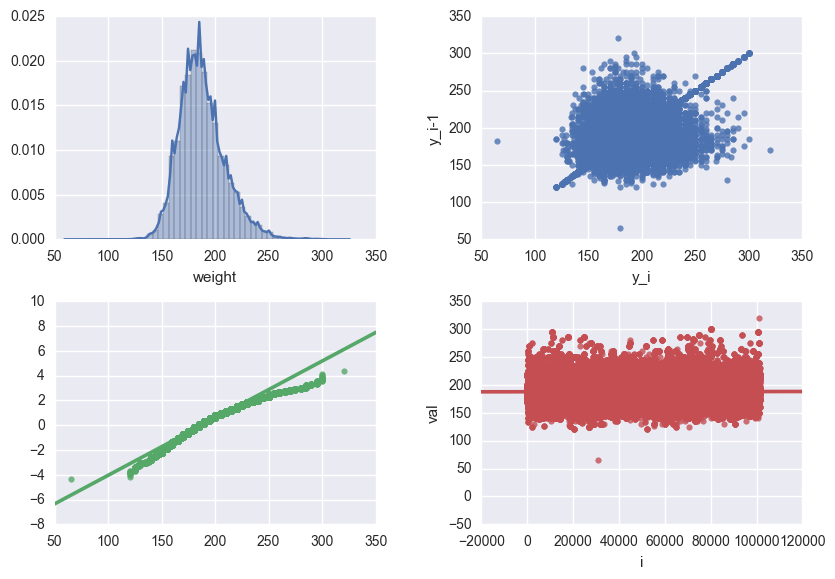

In [23]:
# the histogram looks the same before
# more importantly, we are examining the QQplot here to better visualize normality
fourPlot(MasterPos['weight']) 

## the QQ plot confirms our histogram and we see here that weight is normal

## Because we are also taking height into account for BMI we must now examine height :
once I plotted the height's histogram and looked at the height's qqplot I confirmed that height was also very normal

In [24]:
heighthist = Histogram(MasterPos, 'height', bins = 20, xlabel='height', ylabel='# of Players', plot_width =600, title='Height Distribution',color = 'red')
show(heighthist)

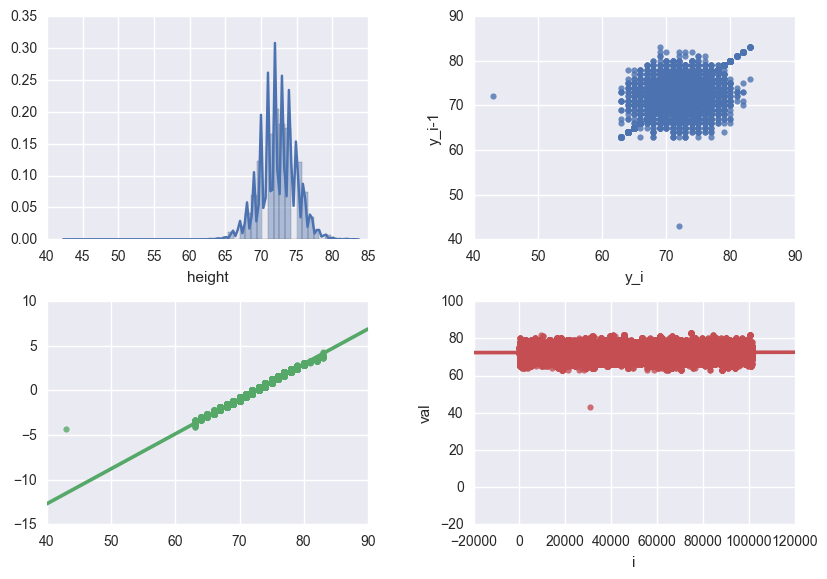

In [25]:
fourPlot(MasterPos['height']) # height is also very normal! QQ plot looks good

In [26]:
## description of BMI

In [27]:
# what does their BMI look like
MasterPos['BMI'] = (MasterPos['weight']/np.power(MasterPos['height'],2)) *703
BMIHist = Histogram(MasterPos,'BMI',bins=30, ylabel='# of Players', title = 'BMI Distribution',color='purple')
show(BMIHist)

In [28]:
# anything below 18.5 is underweight, 25 overweight, and anything past 30 is obsese 
perofBMI = [100 - stats.percentileofscore(MasterPos['BMI'],i) for i in [18.5,26,30,40]]
perofBMI

[99.974360491489662, 27.565430053448509, 2.4870323255034208, 0.0]

In [29]:
100 - perofBMI[0] # 0.025 are underweight
# 27% are overweight and 2.49 are considered obese

0.025639508510337805

# it appears that .025% of players are underweight, 27% are overweight, and 2.49% are considered obese

### Question #2: Have baseball players been getting larger over time?

 lets look at the average weight of baseball players every year 
 because the data stems from 1871 - 2016 this will easier to plot 
 and easier to interpret 

In [31]:
# lets look at the average weight of baseball players every year
AvgLBTS = MasterPos.groupby('yearID')[['weight']].mean()

In [32]:
AvgLBTS.head(2)

weight
yearID                
1871-01-01  157.049505
1872-01-01  158.333333

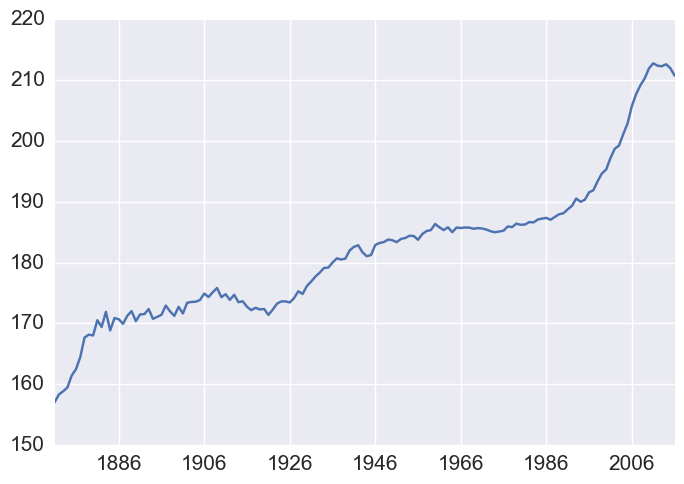

In [33]:
# not very pretty, but this is the timeseries of average weight over time 
ts = AvgLBTS["weight"] 
plt.plot(ts)

## ROLLING AVERAGE FOR MY TIMESERIES ON AVERAGE WEIGHT OVER TIME -  theres a clear trend but rolling average confirms this too. 

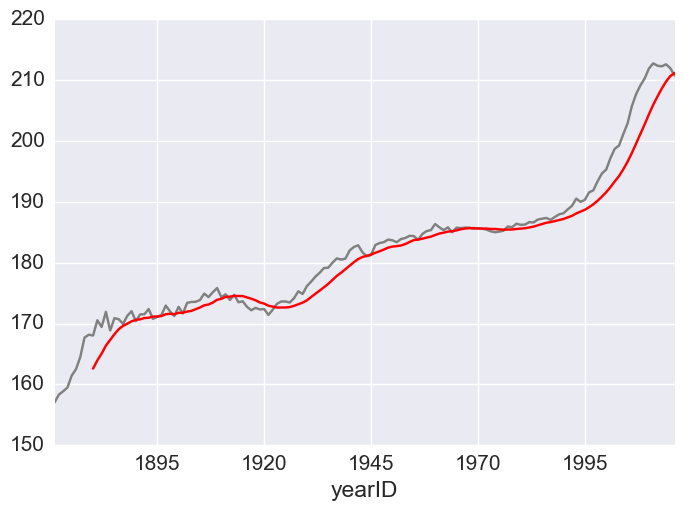

In [34]:
r = AvgLBTS.rolling(window=10)      # windows is you days you want of rolling ; the bigger the window the smaller the varability 
AvgLBTS.weight.plot(color='gray')
r.mean().weight.plot(color='red')


# different ways to visualize my timeseries 

In [35]:
AvgLBTSN_IX = AvgLBTS.reset_index()
AvgLBTSN_IX.head(2)

yearID      weight
0 1871-01-01  157.049505
1 1872-01-01  158.333333

In [36]:
TS = TimeSeries(AvgLBTSN_IX,
    x= "yearID", y='weight', title="Timeseries", ylabel='Average Weight',xlabel='Year',plot_width=400,color='LightBlue', legend=False)
show(TS)

In [37]:
AvgLBTSN_IX_2 = AvgLBTSN_IX.copy()

In [38]:
AvgLBTSN_IX_2['yearID'] = AvgLBTSN_IX_2['yearID'].dt.strftime('%Y')

In [39]:
#specify data source
source = ColumnDataSource(AvgLBTSN_IX_2)
# what pops up to hover 
tooltips = [('weight', '@weight'),
            ('year', '@yearID')]

hover = HoverTool(tooltips=tooltips)


p = figure(plot_width=700,plot_height=450,title="MLB weight over the years", x_axis_label='Year',y_axis_label = "Average Weight (in Pounds)")


# Add the hover tool
p.add_tools(hover)

# # Populate glyphs
p.circle(x='yearID', y='weight', size=7, alpha=0.5, source=source)


show(p)

### Question 3: Does this increase in trend look different if we look at the average weight yearly by position?

In [40]:
AvgLBPos = MasterPos.groupby(['yearID','position'])[['weight']].mean()
AvgLBPos = AvgLBPos.unstack().stack().T.stack()

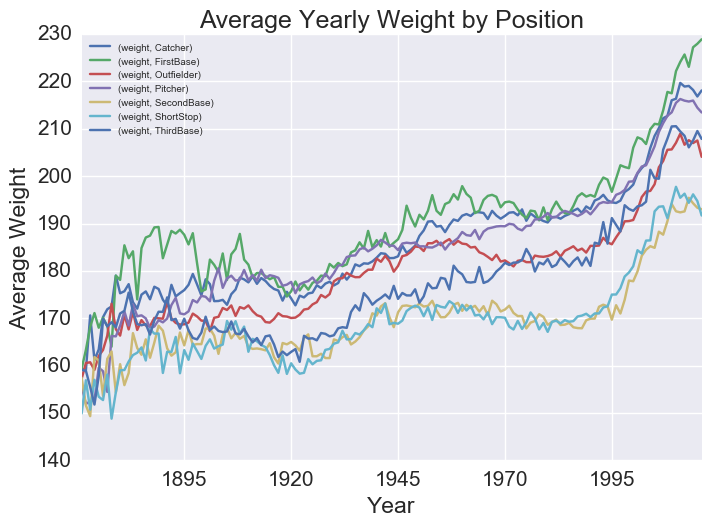

In [41]:
PLOT = AvgLBPos.T.plot(title='Average Yearly Weight by Position')
PLOT.set_xlabel('Year')
PLOT.set_ylabel('Average Weight')
PLOT.legend(loc = 'upper left',fontsize = 7)

# interestingly we can see where different trend lines are. First base is really high above, first base man usually don't cover much ground they stay near first base they dont need to be light , shortstop trend is lower among positions they typically cover more ground and thus being light would be advantageous

# if i had more time I would remove the trend and preform a cross correlation among my position time series to see if they are all correlated or if there is a difference among them. Would specualte that they would be correlated, but further analysis would be required 

### Question 4: after exaiming weight and position, can we classify baseball players position by their weight?

## Naive Bayes

In [43]:
# train the model
gnb_model = sknb.GaussianNB()
# given weight, predict position
gnb_model.fit(MasterPos['weight'].reshape(len(MasterPos['weight']),1),MasterPos["position"])
y_pred = gnb_model.predict(MasterPos['weight'].reshape(len(MasterPos['weight']),1)) # fix this 
MasterPos['predicted_nb'] = y_pred

In [44]:
### skm.accuracy_score(...)
skm.accuracy_score(y_true=MasterPos["position"],y_pred=MasterPos["predicted_nb"])

0.44255763958740113

### Performed a navie bayes with weight and position. Unfortunately, my accuracy score was .44, which is a bad accuracy score.. it's very low. Moving forward by preforming a decision tree classifer 

## bad accuracy score, try decision tree classifier 

## Try Decision Tree

# again here we are looking at classify position by weight

In [46]:
### Weight alone 
dt_model = sktree.DecisionTreeClassifier(max_depth = 2, criterion='entropy')
dt_model.fit(MasterPos[['weight']],MasterPos['position'])
predicted_labels = dt_model.predict(MasterPos[['weight']])
MasterPos['predicted_label_tree'] = predicted_labels

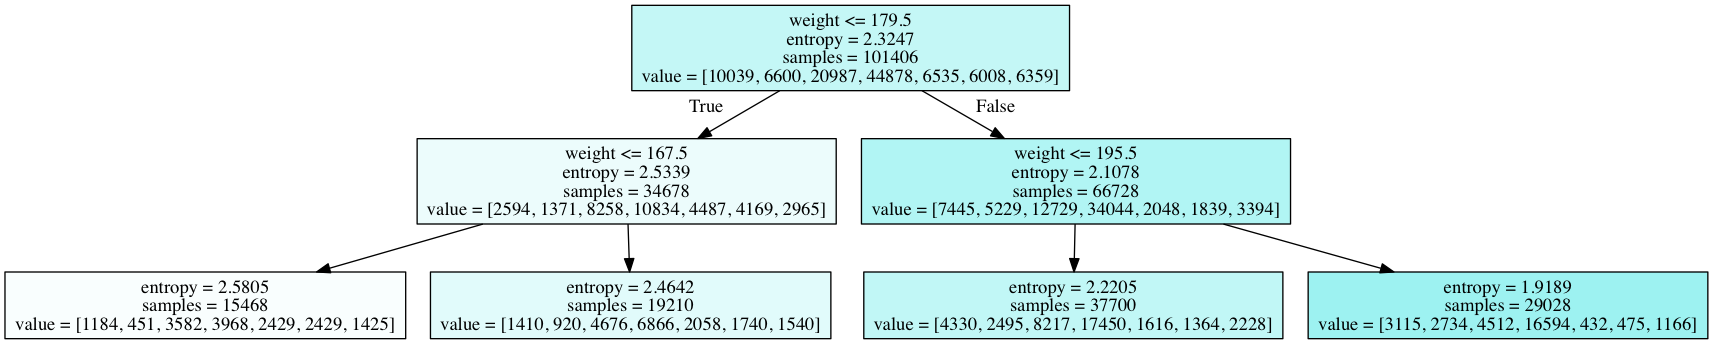

In [47]:
### Weight alone 
dot_data = sksix.StringIO()
sktree.export_graphviz(dt_model, out_file=dot_data,
                       feature_names=['weight'],
                       filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
ipd.Image(graph.create_png())

In [48]:
skm.accuracy_score(y_true=MasterPos["position"],y_pred=MasterPos['predicted_label_tree'])

0.44255763958740113

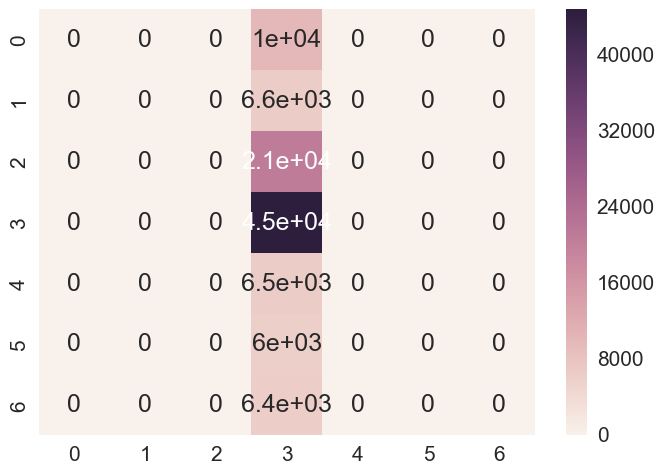

In [49]:
cfmat = skm.confusion_matrix(
    y_true = MasterPos["position"],
    y_pred = MasterPos['predicted_label_tree']
)
sns.heatmap(cfmat, annot=True)

## From the looks of my decision tree and my accuracy score, the model appears to be a bad method to predict position. Accuracy score is .44 again. Examining my confusion matrix it appears that my decision tree is guessing and when it's guessing ( i checked my predicted tree labels) it's guessing all pitchers 

## Moved forward by looking at weight and height as features to predict position however, I got the same results as with weight alone... we see here the bad accuracy score of .44 again and a confusion matrix once again that shows guessing. Moving forward by looking at a distribution of weight by positions.

In [50]:
### Perhaps Height and Weight ? 
dt_model = sktree.DecisionTreeClassifier(max_depth = 2, criterion='entropy')
dt_model.fit(MasterPos[['weight','height']],MasterPos['position'])
predicted_labels = dt_model.predict(MasterPos[['weight','height']])
MasterPos['predicted_label_tree'] = predicted_labels

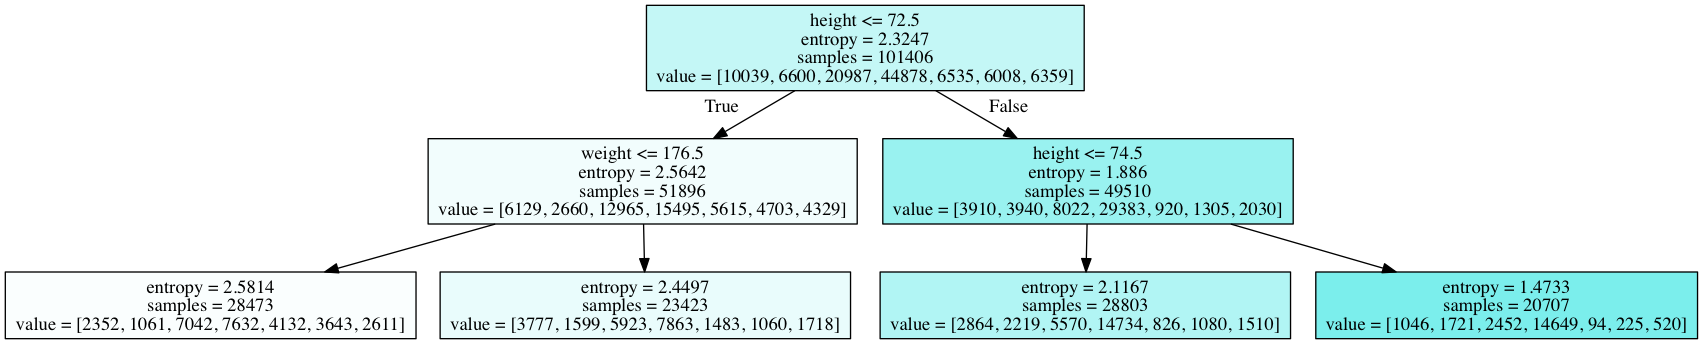

In [51]:
dot_data = sksix.StringIO()
sktree.export_graphviz(dt_model, out_file=dot_data,
                       feature_names=['weight','height'],
                       filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
ipd.Image(graph.create_png())

In [52]:
skm.accuracy_score(y_true=MasterPos["position"],y_pred=MasterPos['predicted_label_tree'])

0.44255763958740113

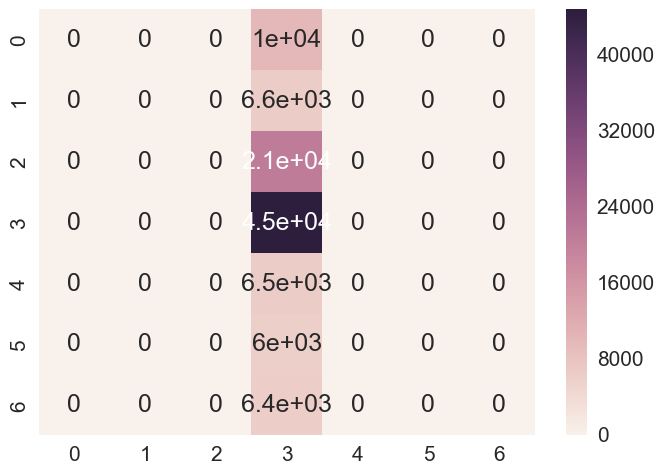

In [53]:
cfmat = skm.confusion_matrix(
    y_true = MasterPos["position"],
    y_pred = MasterPos['predicted_label_tree']
)
sns.heatmap(cfmat, annot=True)

# same thing is occuring when I look at weight and height as features to predict position 

In [54]:
MasterPos.groupby('predicted_label_tree').sum()

weight     height    G_all           BMI
predicted_label_tree                                              
Pitcher               19043154.0  7344848.0  5255467  2.547620e+06

# most labels were being predicted as pitcher 

 looking at the labels and the confusion matrix we can see that the classifier is guessing 

## Why didn't my decision tree work? 

In [57]:
PositionDist = MasterPos.copy()

In [58]:
PositionDist.sort_values(by='position', inplace=True)

hist = Histogram(PositionDist, values='weight', color='position',
                 title="Weight Distribution by Position", legend='top_right')
show(hist)

# the distribution of weights are all heavily overlapping, thus our decision tree classifier was having a hard time creating meaningful cuts in the data. Also, the count of pitchers in this data set appears to be very high ( makes sense a lot of teams usually scout for pitchers) but this may also be why our decision tree predicts pitcher so often.

### Question #5 ( CORRELATION MATRIX) Is there a correlation between a player’s weight and his batting statistics.  Does size matter in terms of batting? 

In [59]:
# create the table you want batting stats and weight 
BatWeight = pd.merge(BattingSel, Weight_df, left_index=True, right_index=True, how='inner')

In [60]:
BatWeight.head(2)

yearID teamID   G  AB  R  H  RBI  HR  2B  3B   SO  weight  \
playerID                                                                  
aardsda01 2004-01-01    SFN  11   0  0  0  0.0   0   0   0  0.0   215.0   
aardsda01 2006-01-01    CHN  45   2  0  0  0.0   0   0   0  0.0   215.0   

           height birthCountry  
playerID                        
aardsda01    75.0          USA  
aardsda01    75.0          USA

In [61]:
# want players who have had the opportunity to bat @ least 100 times
# even if they got 0's but at least they had the opportunity to preform.
BatWeightH = BatWeight[BatWeight.AB > 100]

In [62]:
BatWeightH.head(2)

yearID teamID    G   AB    R    H    RBI  HR  2B  3B    SO  \
playerID                                                                   
aaronha01 1954-01-01    ML1  122  468   58  131   69.0  13  27   6  39.0   
aaronha01 1955-01-01    ML1  153  602  105  189  106.0  27  37   9  61.0   

           weight  height birthCountry  
playerID                                
aaronha01   180.0    72.0          USA  
aaronha01   180.0    72.0          USA

In [63]:
batstat = ['AB','R','H','HR','RBI','3B','2B','SO','weight','height']
cormat = BatWeightH[batstat].corr(method='spearman')
cormat

AB         R         H        HR       RBI        3B        2B  \
AB      1.000000  0.915827  0.976003  0.586704  0.860169  0.490810  0.873101   
R       0.915827  1.000000  0.939047  0.595186  0.868021  0.539548  0.845973   
H       0.976003  0.939047  1.000000  0.596896  0.886594  0.515996  0.895019   
HR      0.586704  0.595186  0.596896  1.000000  0.765460  0.088764  0.657166   
RBI     0.860169  0.868021  0.886594  0.765460  1.000000  0.407006  0.854064   
3B      0.490810  0.539548  0.515996  0.088764  0.407006  1.000000  0.384940   
2B      0.873101  0.845973  0.895019  0.657166  0.854064  0.384940  1.000000   
SO      0.654269  0.564609  0.597863  0.735498  0.622015  0.132344  0.640082   
weight  0.047756  0.039669  0.059651  0.474845  0.231273 -0.236930  0.206781   
height  0.072265  0.026269  0.068915  0.450365  0.206058 -0.201118  0.153021   

              SO    weight    height  
AB      0.654269  0.047756  0.072265  
R       0.564609  0.039669  0.026269  
H       0.597863  0.059651  0.068915  
HR      0.735498  0.474845  0.450365  
RBI     0.622015  0.231273  0.206058  
3B      0.132344 -0.236930 -0.201118  
2B      0.640082  0.206781  0.153021  
SO      1.000000  0.378565  0.417547  
weight  0.378565  1.000000  0.529083  
height  0.417547  0.529083  1.000000

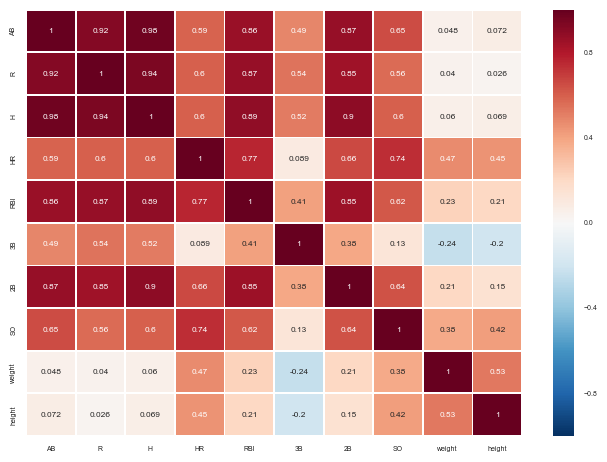

In [68]:
# HR's seems to have the strongest correlation with weight .47
sns.heatmap(cormat,linewidths=.5,annot=True)
sns.set(font_scale=.5)

# here we note that weight is correlated .47 with homeruns this an interesting finding! weight is also correlated with strikeouts .38 and weight is correlated with 3B hits -.25. 
Perhaps when you weight more you have more power meaning you hit farther, but you don't necessary swing faster ( hard to pull a 3 base hit) or maybe you don't run fast enough to get 3rd base hits? 

### Question 6 : Again, what if we dig deeper and look at batting statistics in term of positions: What do batting statistics look like for players who play first base? What about players who play shortstop? (continue if you find more interesting things). Looking for the relationship between batting variables in given subsets of position dataframes. 

# still want players who have batted at least 100 times, the reason being you want to look at batting statistics for players who have at least had the opportunity to bat (even if they suck)

In [69]:
BatWeightH_2 = BatWeightH.copy()
BatWeightH_2 = BatWeightH_2.reset_index() # do this to be able to merge 

In [70]:
Position_df = Position_df.reset_index() # have to do this to merge

In [71]:
Pos_Bats = pd.merge(BatWeightH_2,Position_df,on=['playerID','yearID'])
Pos_Bats = Pos_Bats.set_index('playerID')

In [72]:
Pos_Bats.head(3)

yearID teamID    G   AB    R    H    RBI  HR  2B  3B    SO  \
playerID                                                                   
aaronha01 1954-01-01    ML1  122  468   58  131   69.0  13  27   6  39.0   
aaronha01 1955-01-01    ML1  153  602  105  189  106.0  27  37   9  61.0   
aaronha01 1956-01-01    ML1  153  609  106  200   92.0  26  34  14  54.0   

           weight  height birthCountry    position  
playerID                                            
aaronha01   180.0    72.0          USA  Outfielder  
aaronha01   180.0    72.0          USA  Outfielder  
aaronha01   180.0    72.0          USA  Outfielder

# subset of dataframe by positions ( looking at firstbase and shortstop first )

In [73]:
FB = Pos_Bats[Pos_Bats['position'] == "FirstBase"]
SS = Pos_Bats[Pos_Bats['position'] == "ShortStop"]

In [74]:
#let's look at 5 main batting stats & their weight
Big5_W = ['R','HR','RBI','H','SO','weight']

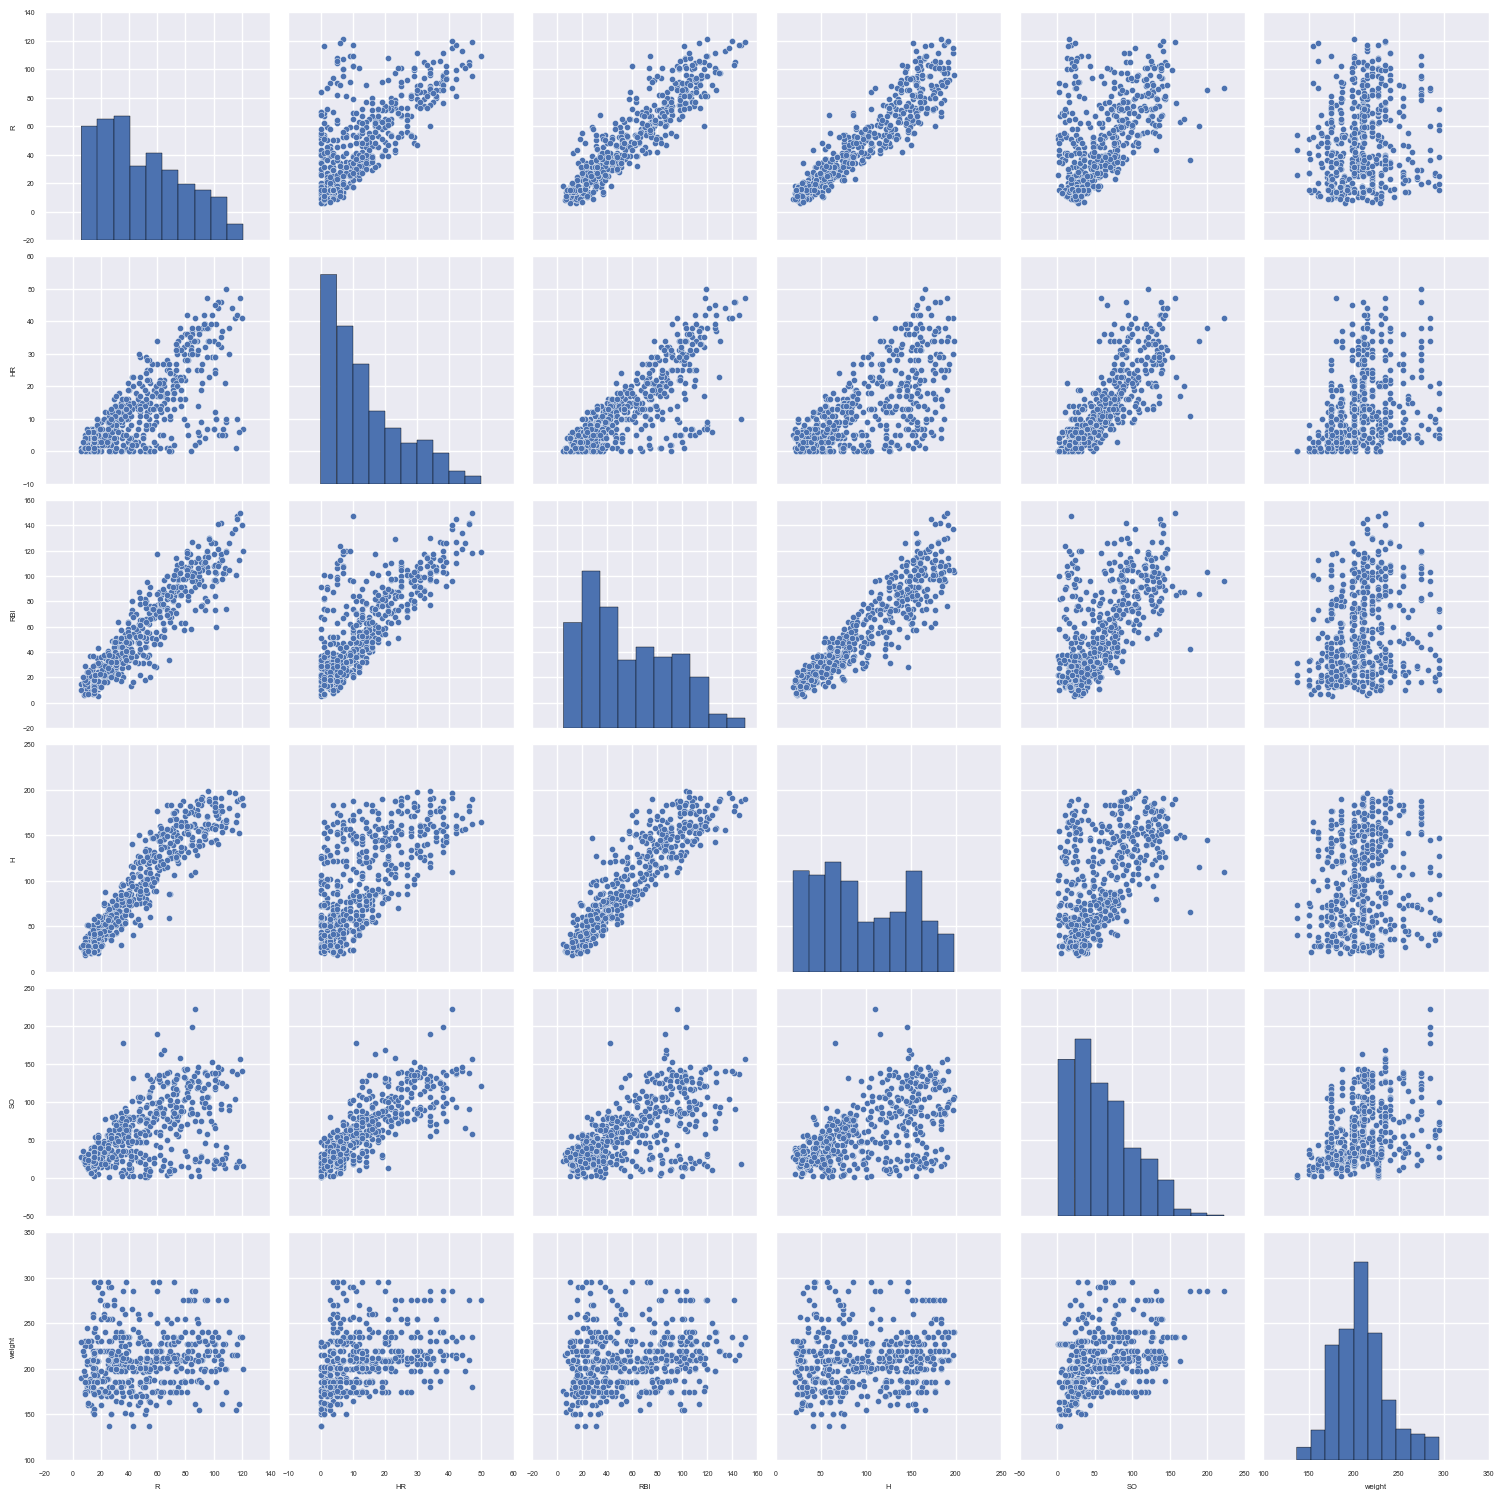

In [75]:
# firstbase
sns.pairplot(FB[Big5_W])

# variables are very skewed, but we do see there is a correlation between RBI's and hits, Strike outs and Homeruns, Weight and strike outs. May be heavier players take longer to swing?

# correlation matrix below confirms what we saw in the splom. only interesting things with weight here is strike outs and homeruns which we saw when we were looking at all players. This isn't very interesting 

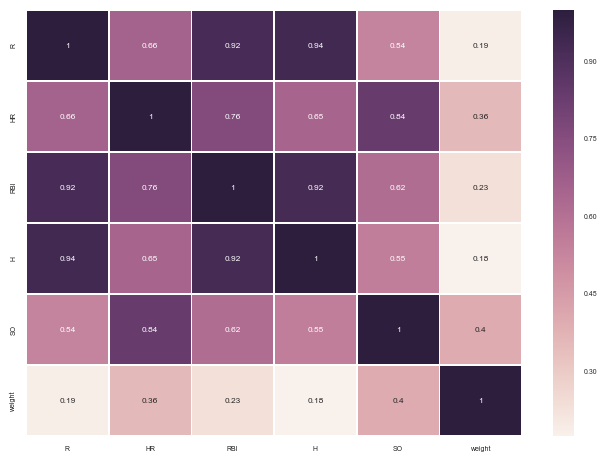

In [76]:
# CONFIRMING AND BETTER VISUALIZING THE CORRELATIONS WE SAW IN SPLOM
cormat = FB[Big5_W].corr(method='spearman') # spearman because vars are skewed
sns.heatmap(cormat,linewidths=.5,annot=True)
sns.set(font_scale=.4)

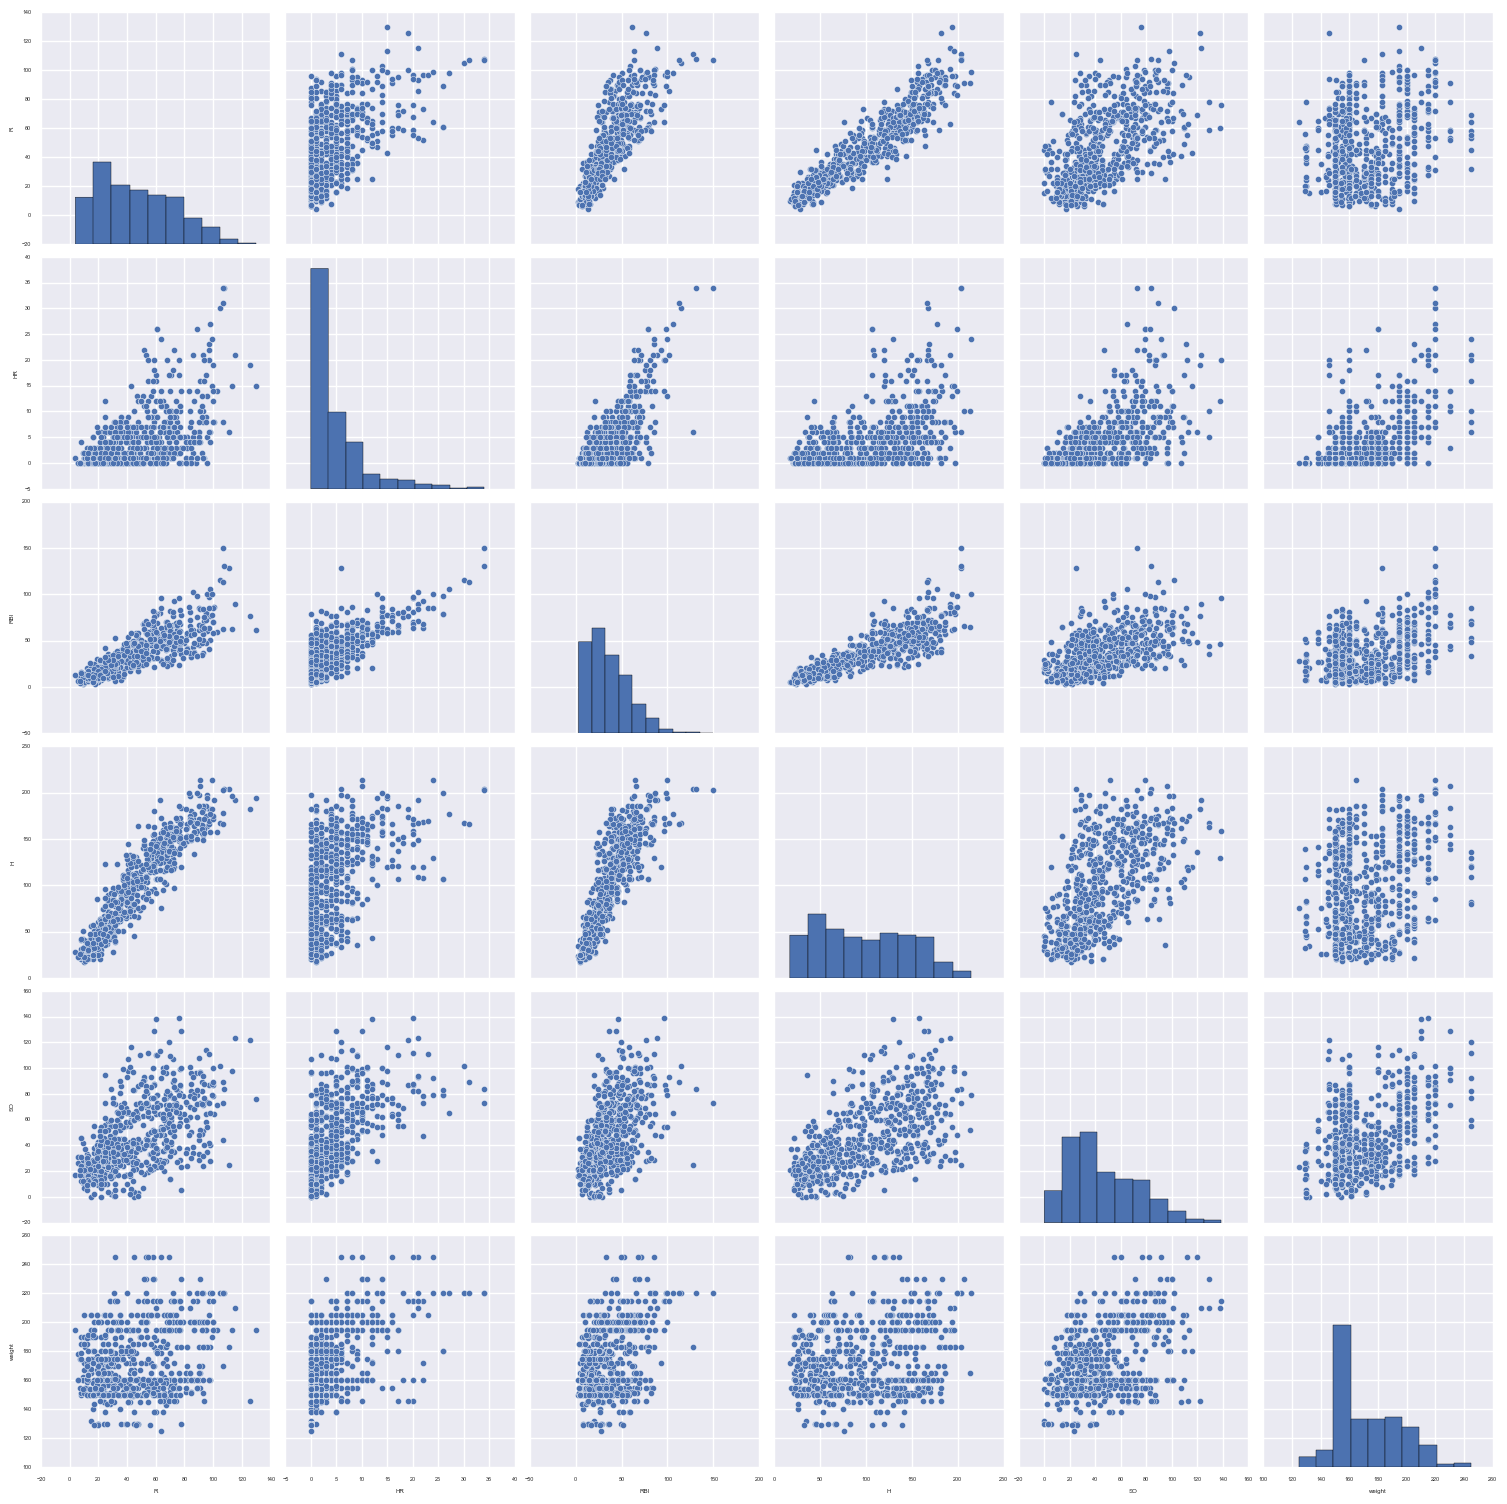

In [77]:
# shortstop
sns.pairplot(SS[Big5_W])
# again variables look skewed

# strong correlation between hits and runs, so and weight, rbis and hits, weight and homeruns

# once again, this finding is similar to the finding we saw in all players. The correlation matrix shows the same. Not interesting

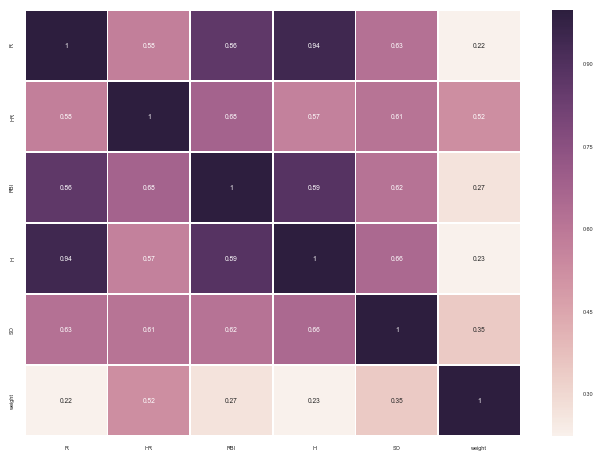

In [78]:
# CONFIRMING AND BETTER VISUALIZING THE CORRELATIONS WE SAW IN SPLOM
cormat = SS[Big5_W].corr(method='spearman')
sns.heatmap(cormat,linewidths=.5,annot=True)
sns.set(font_scale=.4)

### Question 7: In Question 5 we saw the strongest correlation to weight was HomeRuns, can we use homeruns as a dependent variable in linear regression: AVGHR ~ Weight 

In [79]:
AVGHR = BatWeightH.groupby(BatWeightH.index)['HR'].mean()

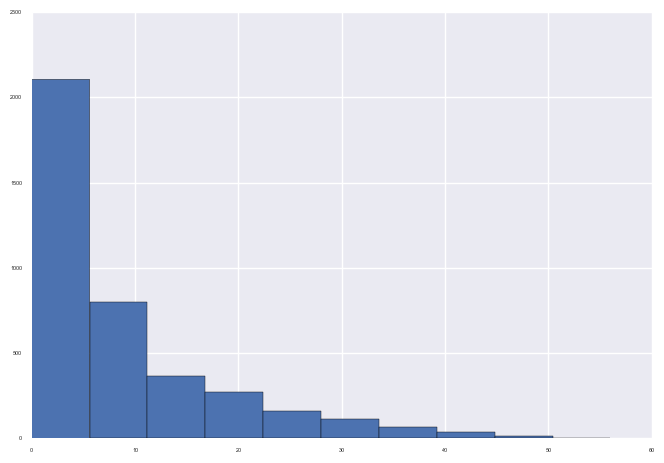

In [80]:
BatWeightH.HR.hist()

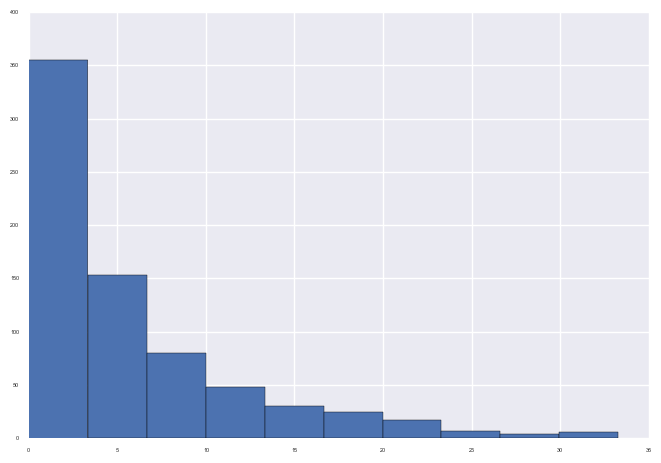

In [81]:
AVGHR.hist()

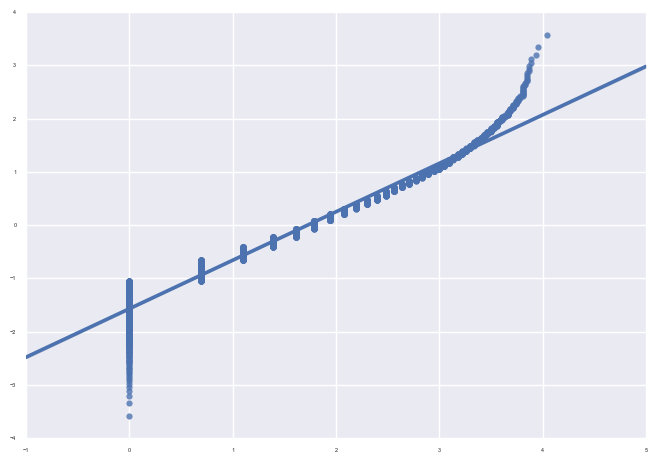

In [82]:
# add 1 so we dont take the log 0 
qntls, xr = stats.probplot(np.log(BatWeightH.HR+1), fit=False)
sns.regplot(xr,qntls)

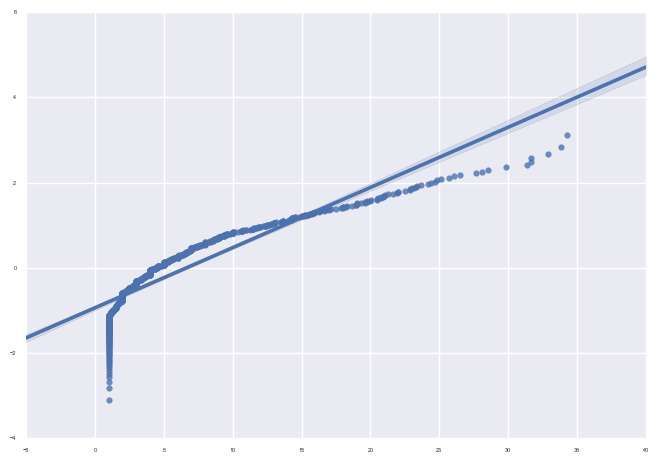

In [85]:
qntls, xr = stats.probplot(AVGHR+1, fit=False)
sns.regplot(xr,qntls)

## we cant use home runs because as we can see from the analyses above homeruns is not normal and log transforming the data doesn't correct the distribution. I didn't want to filter out 0's because as I previously mentioned I looked at players who had the opportunity to bat at least 100 times and thus a 0 for a home run for them doesn't mean they didn't get the chance to hit a homerun, but they didn't do well in terms of homeruns then.

### Question 8: What does the trend for average home runs look like?

In [86]:
AvgHRByYr = BatWeight.groupby('yearID')[['HR']].mean()
AvgHRByYr = AvgHRByYr.reset_index()
AvgHRByYr.head(2)

yearID        HR
0 1871-01-01  0.137931
1 1872-01-01  0.310345

In [87]:
from bokeh.layouts import row
TS = TimeSeries(AvgLBTSN_IX,
    x= "yearID", y='weight', title="Timeseries", ylabel='Average Weight',xlabel='Year',plot_width=400,color='LightBlue', legend=False)

TS2 = TimeSeries(AvgHRByYr,
    x= "yearID", y='HR', title="Timeseries", ylabel='Average HomeRuns',xlabel='Year',plot_width=400,color='LightCoral', legend=False)
show(row(TS,TS2))

# wanted to look at them side by side but home runs looks a bit odd here 

## there seems to be alot of seasonality and trend here in homeruns, if time allows go back and correct for it.

In [88]:
AvgHRByYr['yearID'] = AvgHRByYr['yearID'].dt.strftime('%Y')

In [89]:
source1 = ColumnDataSource(AvgHRByYr)
tooltips1 = [('homeruns', '@HR'),
            ('year', '@yearID')]
hover1 = HoverTool(tooltips=tooltips1)
p1 = figure(plot_width=700,plot_height=450,title="MLB homeruns over the years", x_axis_label='Year',y_axis_label = "Average Homeruns")
# Add the hover tool
p1.add_tools(hover1)
# # Populate glyphs
p1.circle(x='yearID', y='HR', size=7, alpha=0.5, color='LightCoral', source=source1)
show(p1)

### Question 9: Look at Salary data? Has Salary been increasing over the years 

In [90]:
Salaries.describe()

yearID        salary
count  26428.000000  2.642800e+04
mean    2000.878727  2.085634e+06
std        8.909314  3.455348e+06
min     1985.000000  0.000000e+00
25%     1994.000000  2.947020e+05
50%     2001.000000  5.500000e+05
75%     2009.000000  2.350000e+06
max     2016.000000  3.300000e+07

In [91]:
Salaries.dtypes

yearID       int64
teamID      object
lgID        object
playerID    object
salary       int64
dtype: object

In [92]:
Salaries.head(3)

yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115295470>]], dtype=object)

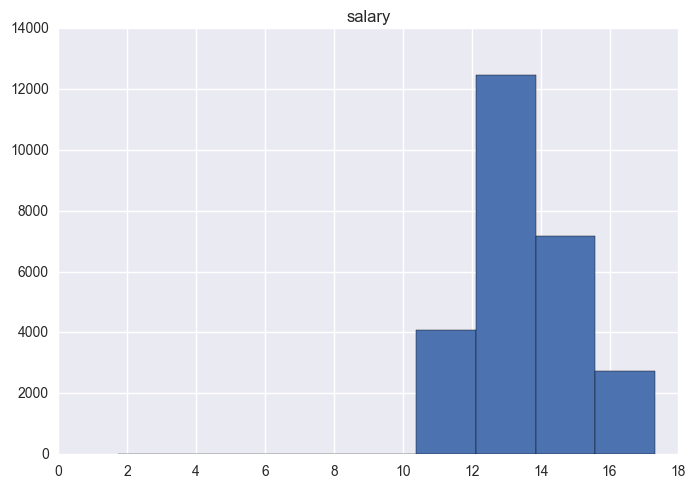

In [99]:
np.log(Salaries[['salary']] + 1).hist()

In [100]:
logSal = np.log(Salaries[['salary']] + 1) 

ValueError: Argument dimensions are incompatible

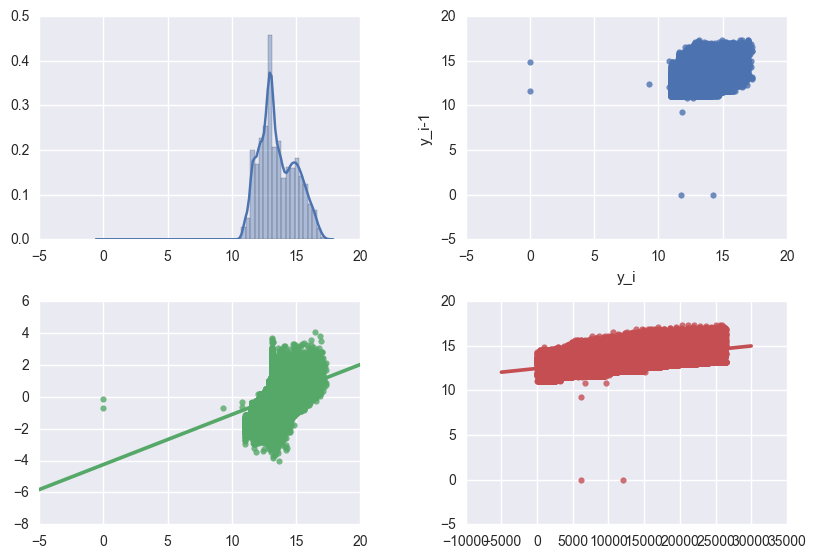

In [101]:
fourPlot(logSal)

# unfortuntely, salaries are highly skewed and not normal looking at the histogram and QQplot also would have to normalize by inflation if I would like to make better comparisons. 

In [102]:
s = BoxPlot(Salaries, values='salary', label='yearID', color='yearID',
               title="Salary Box Plot by Year", width = 900, height=900)
show(s)

# can see how very skewed baseball data salary can be! Think about interpreting it via a rank or looking at 1 year

In [103]:
# Salaries.groupby('yearID').mean()
# # salaries started at 476,299 - 4,396,409
# what about their median 
# Salaries.groupby('yearID').median()
# the median is 400,000 - 1,500,000

# for a later question, found that CUBS TEAM ID changed from CHN to CHC

In [176]:
Salaries['teamID'] = Salaries['teamID'].replace('CHC','CHN')

### Question 10: Look at Team data: winning percentage??? Can we predict team wins from their run differental?

In [114]:
Teams.head(3)

yearID lgID teamID franchID divID  Rank   G  Ghome   W   L    ...     \
0    1871  NaN    BS1      BNA   NaN     3  31    NaN  20  10    ...      
1    1871  NaN    CH1      CNA   NaN     2  28    NaN  19   9    ...      
2    1871  NaN    CL1      CFC   NaN     8  29    NaN  10  19    ...      

                      name                          park attendance  BPF  PPF  \
0     Boston Red Stockings           South End Grounds I        NaN  103   98   
1  Chicago White Stockings       Union Base-Ball Grounds        NaN  104  102   
2   Cleveland Forest Citys  National Association Grounds        NaN   96  100   

   teamIDBR  teamIDlahman45  teamIDretro  rundiffer    WinPCT  
0       BOS             BS1          BS1   3.161290  2.000000  
1       CHI             CH1          CH1   2.178571  2.111111  
2       CLE             CL1          CL1  -3.172414  0.526316  

[3 rows x 50 columns]

In [116]:
Teams.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro', 'rundiffer', 'WinPCT'],
      dtype='object')

correlation matrix? / fix teams 

In [104]:
cormat = Teams[['Rank','W','L','R','RA','G','H','HR']].corr(method='spearman')
cormat

Rank         W         L         R        RA         G         H  \
Rank  1.000000 -0.802936  0.640078 -0.461716  0.354872 -0.215474 -0.344883   
W    -0.802936  1.000000 -0.479683  0.575176 -0.245282  0.424013  0.535419   
L     0.640078 -0.479683  1.000000 -0.227971  0.601784  0.393433  0.048469   
R    -0.461716  0.575176 -0.227971  1.000000  0.436685  0.241643  0.756482   
RA    0.354872 -0.245282  0.601784  0.436685  1.000000  0.223953  0.436411   
G    -0.215474  0.424013  0.393433  0.241643  0.223953  1.000000  0.469437   
H    -0.344883  0.535419  0.048469  0.756482  0.436411  0.469437  1.000000   
HR   -0.350280  0.449273  0.179071  0.512921  0.333897  0.695038  0.536833   

            HR  
Rank -0.350280  
W     0.449273  
L     0.179071  
R     0.512921  
RA    0.333897  
G     0.695038  
H     0.536833  
HR    1.000000

## strongest correlation with wins was run and hits, look into run differential

In [105]:
Teams['rundiffer'] = (Teams['R'] - Teams['RA']) / Teams.G

## teams.G is the number of games, so I divided by this to normalize for seasons where there may have been less games 

In [106]:
Teams['WinPCT'] = Teams['W'] / Teams['L']

In [107]:
Teams20 = Teams[Teams['yearID'] > 1999]

## model1 is looking at 2000 through 2016

In [108]:
model1 = smf.ols('WinPCT ~ rundiffer', data=Teams20).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPCT   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     2669.
Date:                Tue, 18 Apr 2017   Prob (F-statistic):          2.28e-204
Time:                        09:15:39   Log-Likelihood:                 371.99
No. Observations:                 510   AIC:                            -740.0
Df Residuals:                     508   BIC:                            -731.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0403      0.005    200.951      0.000         1.030     1.050
rundiffer      0.4120      0.008     51.664      0.000         0.396     0.428
==============================================================================
Omnibus:                       89.089   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.117
Skew:                           0.862   Prob(JB):                     3.24e-52
Kurtosis:                       5.861   Cond. No.                         1.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# the model accounts for .84 percent of the variation in win percentage. My predictor run differential is also statistically signifcant. So, it's important to take runs scored and runs allowed when thinking about a teams winning percentage

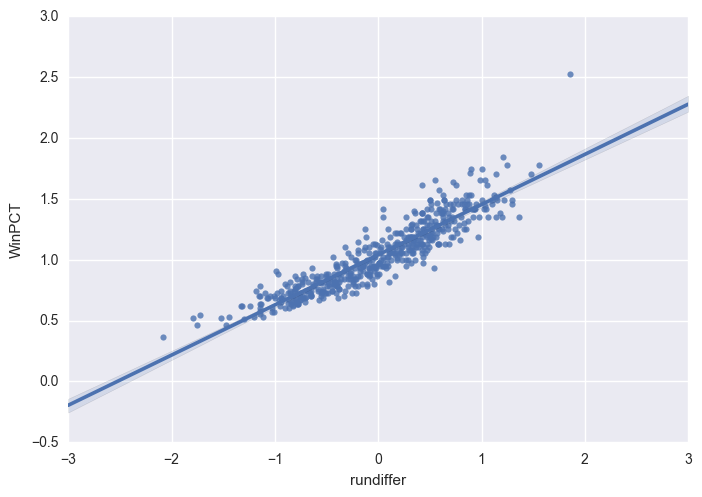

In [109]:
sns.regplot(x='rundiffer', y='WinPCT', data=Teams20)

## performing outlier detection using dffits 

In [230]:
influence = model1.get_influence()

# Find outliers using DFFITS
number_of_observations = len(Teams20)
number_of_parameters = 2  # parameters include: intercept, x
dffits = influence.dffits[0]

# Use an empirical threshold
dffits_threshold = 2 * np.sqrt(number_of_parameters / number_of_observations)
Teams20[np.abs(dffits) > dffits_threshold]

yearID lgID teamID franchID divID  Rank    G  Ghome    W    L    ...     \
2379    2001   AL    SEA      SEA     W     1  162   81.0  116   46    ...      
2387    2002   NL    ATL      ATL     E     1  161   81.0  101   59    ...      
2389    2002   AL    BOS      BOS     E     2  162   81.0   93   69    ...      
2395    2002   AL    DET      DET     C     5  161   80.0   55  106    ...      
2403    2002   AL    NYA      NYY     E     1  161   80.0  103   58    ...      
2405    2002   AL    OAK      OAK     W     1  162   81.0  103   59    ...      
2417    2003   NL    ATL      ATL     E     1  162   81.0  101   61    ...      
2422    2003   NL    CIN      CIN     C     5  162   81.0   69   93    ...      
2425    2003   AL    DET      DET     C     5  162   81.0   43  119    ...      
2433    2003   AL    NYA      NYY     E     1  163   82.0  101   61    ...      
2440    2003   NL    SFN      SFG     W     1  161   81.0  100   61    ...      
2446    2004   NL    ARI      ARI     W     5  162   81.0   51  111    ...      
2452    2004   NL    CIN      CIN     C     4  162   81.0   76   86    ...      
2463    2004   AL    NYA      NYY     E     1  162   81.0  101   61    ...      
2471    2004   NL    SLN      STL     C     1  162   81.0  105   57    ...      
2475    2005   NL    ARI      ARI     W     2  162   81.0   77   85    ...      
2479    2005   AL    CHA      CHW     C     1  162   81.0   99   63    ...      
2512    2006   AL    CLE      CLE     C     4  162   81.0   78   84    ...      
2578    2008   AL    LAA      ANA     W     1  162   81.0  100   62    ...      
2612    2009   AL    NYA      NYY     E     1  162   81.0  103   59    ...      
2646    2010   NL    PIT      PIT     C     6  162   81.0   57  105    ...      
2675    2011   NL    PHI      PHI     E     1  162   81.0  102   60    ...      
2764    2014   AL    OAK      OAK     W     2  162   81.0   88   74    ...      
2800    2015   NL    SLN      STL     C     1  162   81.0  100   62    ...      
2803    2015   AL    TOR      TOR     E     1  162   81.0   93   69    ...      
2825    2016   NL    PHI      PHI     E     4  162   81.0   71   91    ...      
2832    2016   AL    TEX      TEX     W     1  162   81.0   95   67    ...      

                               name                           park attendance  \
2379               Seattle Mariners                   Safeco Field  3507326.0   
2387                 Atlanta Braves                   Turner Field  2603484.0   
2389                 Boston Red Sox                 Fenway Park II  2650862.0   
2395                 Detroit Tigers                  Comerica Park  1503623.0   
2403               New York Yankees              Yankee Stadium II  3465807.0   
2405              Oakland Athletics               Oakland Coliseum  2169811.0   
2417                 Atlanta Braves                   Turner Field  2401084.0   
2422                Cincinnati Reds       Great American Ball Park  2355259.0   
2425                 Detroit Tigers                  Comerica Park  1368245.0   
2433               New York Yankees              Yankee Stadium II  3465600.0   
2440           San Francisco Giants                   PacBell Park  3264898.0   
2446           Arizona Diamondbacks              Bank One Ballpark  2519560.0   
2452                Cincinnati Reds       Great American Ball Park  2287250.0   
2463               New York Yankees              Yankee Stadium II  3775292.0   
2471            St. Louis Cardinals               Busch Stadium II  3048427.0   
2475           Arizona Diamondbacks              Bank One Ballpark  2059424.0   
2479              Chicago White Sox            U.S. Cellular Field  2342833.0   
2512              Cleveland Indians                   Jacobs Field  1997995.0   
2578  Los Angeles Angels of Anaheim                  Angel Stadium  3336747.0   
2612               New York Yankees             Yankee Stadium III  3719358.0   
2646             Pittsburgh Pirates 

## found a handful of outliers lets look at how they appear in terms of threshold?

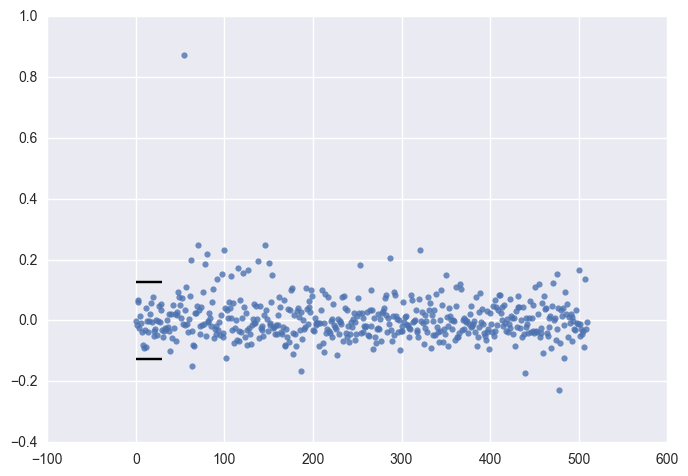

In [233]:
ax = sns.regplot(np.arange(len(dffits)),dffits,ci=0,fit_reg=False)
plt.hlines(dffits_threshold,0,30)
plt.hlines(-dffits_threshold,0,30)

# removing outliers 

In [235]:
cleaned_teams20 = Teams20[np.abs(dffits) < dffits_threshold]
model2 = smf.ols('WinPCT ~ rundiffer', data=cleaned_teams20).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPCT   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     3127.
Date:                Tue, 18 Apr 2017   Prob (F-statistic):          1.34e-212
Time:                        18:14:18   Log-Likelihood:                 444.13
No. Observations:                 483   AIC:                            -884.3
Df Residuals:                     481   BIC:                            -875.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0290      0.004    233.875      0.000         1.020     1.038
rundiffer      0.4055      0.007     55.919      0.000         0.391     0.420
==============================================================================
Omnibus:                        4.180   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.268
Skew:                           0.221   Prob(JB):                        0.118
Kurtosis:                       2.872   Cond. No.                         1.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# after outlier analysis is run and removing them the model gets slightly better we go from and adjusted r square of .84 to .86. Not a very big difference!!

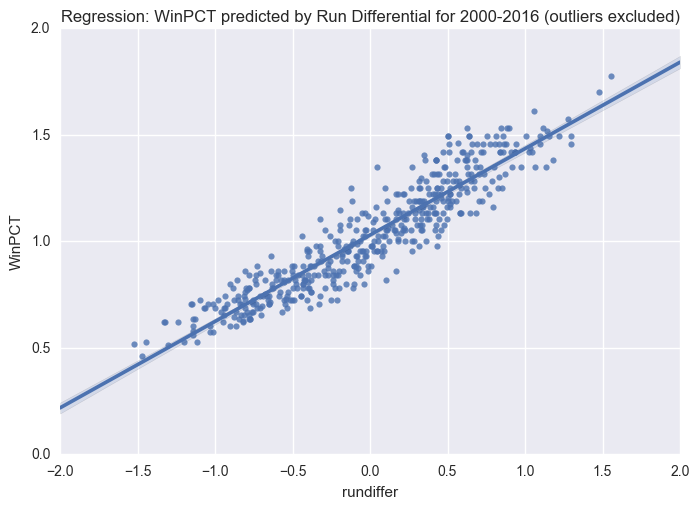

In [248]:
sns.regplot(x='rundiffer', y='WinPCT', data=cleaned_teams20)
sns.plt.title('Regression: WinPCT predicted by Run Differential for 2000-2016 (outliers excluded)')

## trying this again but with data from 1871 and so on. This is a very very large amount of observations

In [237]:
model3 = smf.ols('WinPCT ~ rundiffer', data=Teams).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPCT   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     5092.
Date:                Tue, 18 Apr 2017   Prob (F-statistic):               0.00
Time:                        18:29:55   Log-Likelihood:                -254.47
No. Observations:                2835   AIC:                             512.9
Df Residuals:                    2833   BIC:                             524.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0799      0.005    217.069      0.000         1.070     1.090
rundiffer      0.3081      0.004     71.361      0.000         0.300     0.317
==============================================================================
Omnibus:                     4283.460   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3122273.381
Skew:                           8.979   Prob(JB):                         0.00
Kurtosis:                     164.584   Cond. No.                         1.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

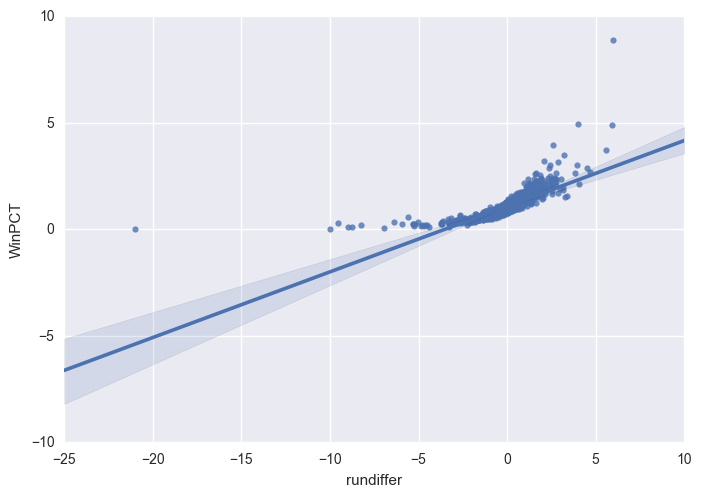

In [238]:
sns.regplot(x='rundiffer', y='WinPCT', data=Teams)

In [239]:
influence = model3.get_influence()

# Find outliers using DFFITS
number_of_observations = len(Teams)
number_of_parameters = 2  # parameters include: intercept, x
dffits = influence.dffits[0]

# Use an empirical threshold
dffits_threshold = 2 * np.sqrt(number_of_parameters / number_of_observations)
Teams[np.abs(dffits) > dffits_threshold]

yearID lgID teamID franchID divID  Rank    G  Ghome    W   L    ...     \
1       1871  NaN    CH1      CNA   NaN     2   28    NaN   19   9    ...      
2       1871  NaN    CL1      CFC   NaN     8   29    NaN   10  19    ...      
3       1871  NaN    FW1      KEK   NaN     7   19    NaN    7  12    ...      
5       1871  NaN    PH1      PNA   NaN     1   28    NaN   21   7    ...      
10      1872  NaN    BR1      ECK   NaN     9   29    NaN    3  26    ...      
11      1872  NaN    BR2      BRA   NaN     6   37    NaN    9  28    ...      
12      1872  NaN    BS1      BNA   NaN     1   48    NaN   39   8    ...      
13      1872  NaN    CL1      CFC   NaN     7   22    NaN    6  16    ...      
14      1872  NaN    MID      MAN   NaN     8   24    NaN    5  19    ...      
17      1872  NaN    TRO      TRO   NaN     5   25    NaN   15  10    ...      
18      1872  NaN    WS3      OLY   NaN    10    9    NaN    2   7    ...      
19      1872  NaN    WS4      NAT   NaN    11   11    NaN    0  11    ...      
20      1873  NaN    BL1      BLC   NaN     3   57    NaN   34  22    ...      
21      1873  NaN    BL4      MAR   NaN     9    6    NaN    0   6    ...      
22      1873  NaN    BR2      BRA   NaN     6   55    NaN   17  37    ...      
24      1873  NaN    ELI      RES   NaN     8   23    NaN    2  21    ...      
28      1873  NaN    WS5      WBL   NaN     7   39    NaN    8  31    ...      
29      1874  NaN    BL1      BLC   NaN     8   47    NaN    9  38    ...      
30      1874  NaN    BR2      BRA   NaN     6   56    NaN   22  33    ...      
31      1874  NaN    BS1      BNA   NaN     1   71    NaN   52  18    ...      
37      1875  NaN    BR2      BRA   NaN    11   44    NaN    2  42    ...      
38      1875  NaN    BS1      BNA   NaN     1   82    NaN   71   8    ...      
42      1875  NaN    NH1      NHV   NaN     8   47    NaN    7  40    ...      
44      1875  NaN    PH1      PNA   NaN     2   77    NaN   53  20    ...      
46      1875  NaN    PH3      CEN   NaN    11   14    NaN    2  12    ...      
47      1875  NaN    SL1      SLR   NaN    10   19    NaN    4  15    ...      
49      1875  NaN    WS6      WNT   NaN     9   28    NaN    5  23    ...      
51      1876   NL    CHN      CHC   NaN     1   66    NaN   52  14    ...      
52      1876   NL    CN1      CNR   NaN     8   65    NaN    9  56    ...      
53      1876   NL    HAR      HAR   NaN     2   69    NaN   47  21    ...      
...      ...  ...    ...      ...   ...   ...  ...    ...  ...  ..    ...      
523     1909   NL    PIT      PIT   NaN     1  154   78.0  110  42    ...      
531     1910   NL    CHN      CHC   NaN     1  154   77.0  104  50    ...      
537     1910   AL    PHA      OAK   NaN     1  155   78.0  102  48    ...      
553     1911   AL    PHA      OAK   NaN     1  152   75.0  101  50    ...      
559     1912   AL    BOS      BOS   NaN     1  154   78.0  105  47    ...      
567     1912   NL    NY1      SFG   NaN     1  154   76.0  103  48    ...      
583     1913   NL    NY1      SFG   NaN     1  156   81.0  101  51    ...      
616     1915   AL    BOS      BOS   NaN     1  155   76.0  101  50    ...      
692     1919   NL    CIN      CIN   NaN     1  140   70.0   96  44    ...      
824     1927   AL    NYA      NYY   NaN     1  155   77.0  110  44    ...      
857     1929   AL    PHA      OAK   NaN     1  151   74.0  104  46    ...      
889     1931   AL    PHA      OAK   NaN     1  153   75.0  107  45    ...      
904     1932   AL    NYA      NYY   NaN     1  156   77.0  107  47    ...      
1016    1939   AL    NYA      NYY   NaN     1  152   77.0  106  45    ...      
1056    1942   NL    BRO      LAD   NaN     2  155   79.0  104  50    ...      
1069    1942   NL    SLN      STL   NaN     1  156   78.0  106  48    ...      
1085    1943   NL    SLN      STL   NaN     1  157   81.0  105  49    ...      
1101    1944   NL    SLN      STL   NaN     1  157   77.0  105  49    ...      
1119  

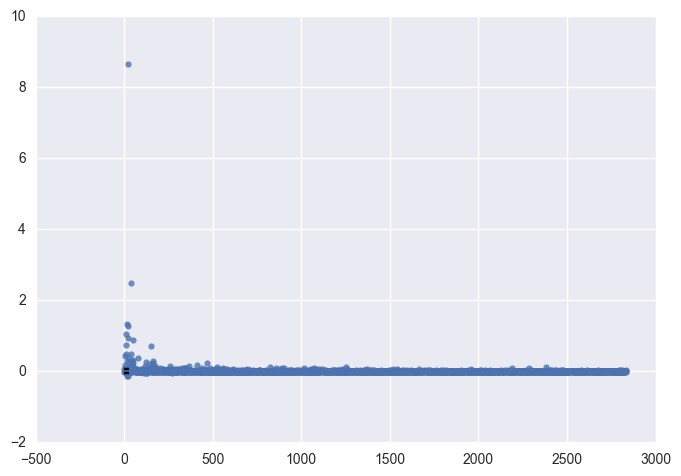

In [240]:
ax = sns.regplot(np.arange(len(dffits)),dffits,ci=0,fit_reg=False)
plt.hlines(dffits_threshold,0,30)
plt.hlines(-dffits_threshold,0,30)

## so much data but we can see there a handful of outliers that are past the two dark line on our plot

## here taking out the outliers did make a significant difference our model went from .64 to .848 so appears that the outliers in this observation hold more influence then the previous model. This model also contains more points

In [241]:
cleaned_teams = Teams[np.abs(dffits) < dffits_threshold]
model4 = smf.ols('WinPCT ~ rundiffer', data=cleaned_teams).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinPCT   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                 1.526e+04
Date:                Tue, 18 Apr 2017   Prob (F-statistic):               0.00
Time:                        18:30:25   Log-Likelihood:                 1638.9
No. Observations:                2731   AIC:                            -3274.
Df Residuals:                    2729   BIC:                            -3262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0512      0.003    413.344      0.000         1.046     1.056
rundiffer      0.3746      0.003    123.532      0.000         0.369     0.381
==============================================================================
Omnibus:                      111.425   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.028
Skew:                           0.470   Prob(JB):                     5.82e-29
Kurtosis:                       3.510   Cond. No.                         1.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

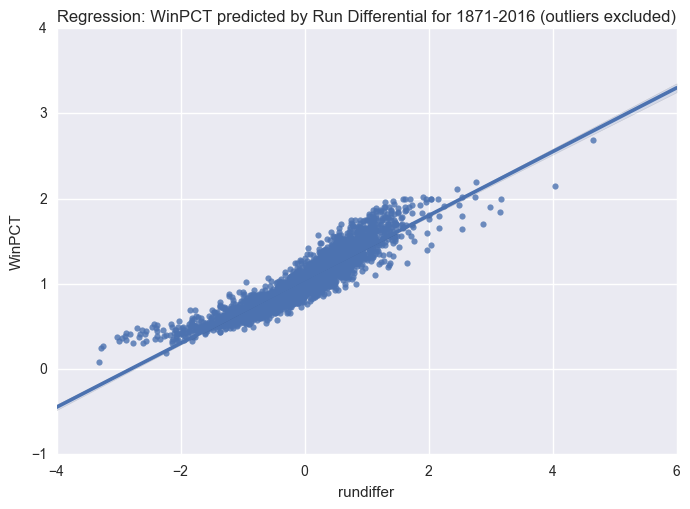

In [247]:
sns.regplot(x='rundiffer', y='WinPCT', data=cleaned_teams)
sns.plt.title('Regression: WinPCT predicted by Run Differential for 1871-2016 (outliers excluded)')

### Question 11: Looking at salaries and teams? Do team with higher Payrolls win more World Series?


In [ ]:
# group salary by year id and team 

In [215]:
SalbyYrTeam = Salaries[Salaries['yearID'] >= 1985]['salary'].groupby([Salaries['yearID'],Salaries['teamID']]).sum()

In [216]:
# now look at the world series winners 

In [217]:
WSW = Teams[(Teams['yearID']>= 1985) & (Teams['WSWin'] == 'Y')][['yearID','teamID','name']]

In [218]:
## itterate through the rows of world series winners, create payroll and pay roll rank
# sal by yr and team has the annual salary : payroll for that year for that team
# for pay roll rank, make sure it's given to the right team id
# (go back and look @ sals some error??)

In [219]:
for index, row in WSW.iterrows():
    AnnSals = SalbyYrTeam[row['yearID']]
    WSW.set_value(index, 'payroll', AnnSals[row['teamID']])
    WSW.set_value(index, 'payroll_rank', AnnSals.rank(ascending=False)[row['teamID']])

# go back and check that salaries is corrected.  you want to make sure you change CHC to CHN, dang cubbies! They changed their teamid in 2016 to CHC. 

In [220]:
WSW

yearID teamID                   name      payroll  payroll_rank
1927    1985    KCA     Kansas City Royals    9321179.0          17.0
1959    1986    NYN          New York Mets   15393714.0           4.0
1981    1987    MIN        Minnesota Twins    6397500.0          24.0
2006    1988    LAN    Los Angeles Dodgers   16850515.0           2.0
2038    1989    OAK      Oakland Athletics   15613070.0           8.0
2053    1990    CIN        Cincinnati Reds   14370000.0          21.0
2085    1991    MIN        Minnesota Twins   23361833.0          12.0
2124    1992    TOR      Toronto Blue Jays   44788666.0           1.0
2152    1993    TOR      Toronto Blue Jays   47279166.0           1.0
2181    1995    ATL         Atlanta Braves   47235445.0           3.0
2226    1996    NYA       New York Yankees   54191792.0           2.0
2247    1997    FLO        Florida Marlins   48692500.0           8.0
2283    1998    NYA       New York Yankees   66806867.0           2.0
2313    1999    NYA       New York Yankees   86734359.0           1.0
2343    2000    NYA       New York Yankees   92338260.0           1.0
2356    2001    ARI   Arizona Diamondbacks   85082999.0           8.0
2385    2002    ANA         Anaheim Angels   61721667.0          15.0
2426    2003    FLO        Florida Marlins   49450000.0          24.0
2449    2004    BOS         Boston Red Sox  127298500.0           2.0
2479    2005    CHA      Chicago White Sox   75178000.0          13.0
2530    2006    SLN    St. Louis Cardinals   88891371.0          10.0
2538    2007    BOS         Boston Red Sox  143026214.0           2.0
2585    2008    PHI  Philadelphia Phillies   97879880.0          12.0
2612    2009    NYA       New York Yankees  201449189.0           1.0
2649    2010    SFN   San Francisco Giants   98641333.0           9.0
2680    2011    SLN    St. Louis Cardinals  105433572.0          11.0
2709    2012    SFN   San Francisco Giants  117620683.0           8.0
2718    2013    BOS         Boston Red Sox  151530000.0           4.0
2769    2014    SFN   San Francisco Giants  163510167.0           4.0
2786    2015    KCA     Kansas City Royals  112107025.0          17.0
2810    2016    CHN           Chicago Cubs  154067668.0           8.0

In [221]:
Rank_Wins = WSW['payroll_rank'].value_counts().reset_index()
Rank_Wins.columns = ['payroll_rank', 'winsby_rank']
Rank_Wins

payroll_rank  winsby_rank
0            8.0            5
1            2.0            5
2            1.0            5
3            4.0            3
4           24.0            2
5           17.0            2
6           12.0            2
7           21.0            1
8           15.0            1
9           13.0            1
10          11.0            1
11          10.0            1
12           9.0            1
13           3.0            1

## Looks like times with higher payroll rank in a season win more world series games!

In [224]:
p = Bar(Rank_Wins, 'payroll_rank', values='winsby_rank', title="World Series Win by Pay Roll Rank",legend=False)
show(p)

In [231]:
ct = pd.crosstab(Rank_Wins['winsby_rank'],Rank_Wins['payroll_rank'])
ct.head()

payroll_rank  1.0   2.0   3.0   4.0   8.0   9.0   10.0  11.0  12.0  13.0  \
winsby_rank                                                                
1                0     0     1     0     0     1     1     1     0     1   
2                0     0     0     0     0     0     0     0     1     0   
3                0     0     0     1     0     0     0     0     0     0   
5                1     1     0     0     1     0     0     0     0     0   

payroll_rank  15.0  17.0  21.0  24.0  
winsby_rank                           
1                1     0     1     0  
2                0     1     0     1  
3                0     0     0     0  
5                0     0     0     0

In [232]:
from scipy.stats import chi2_contingency
chi2,p,dof,ex = chi2_contingency(ct)

print('chi2 =', chi2)
print('p-val =', p)
print('degrees of freedom = ', dof)
print('Expected: ')
pd.DataFrame(ex)


chi2 = 42.0
p-val = 0.342205863116
degrees of freedom =  39
Expected: 


0         1         2         3         4         5         6   \
0  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
1  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286   
2  0.071429  0.071429  0.071429  0.071429  0.071429  0.071429  0.071429   
3  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286   

         7         8         9         10        11        12        13  
0  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000  
1  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286  
2  0.071429  0.071429  0.071429  0.071429  0.071429  0.071429  0.071429  
3  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286  0.214286

# our chi squared would tell us we fail to reject the null that these two variables are independent of each other. Howeverm it is important to not that this test could be an error or not significant due to the small sample size, only one world series winner a year. Yet without more data ( which isn't possible until another world series win) we can't claim this result to be statistically significant. 

 ### FIN!